In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol
from astropy import constants as const
from astropy import units
from sympy import re
from scipy.integrate import quad, dblquad
import scipy.optimize as spopt
from scipy.interpolate import interp1d

plt.rcParams.update({'font.size': 13})

In [159]:
def rho0(r_0, gamma): # from Gondolo and Silk
    return (1-gamma/3)*0.0062*(8500/r_0)**gamma

/home/jagoras/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


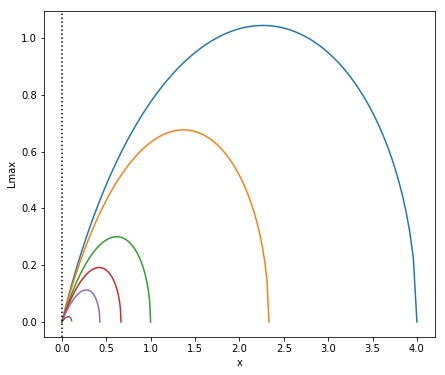

In [6]:
def lmax(eps, x):
    return (2*x**2*(1/(1+x) - eps))**0.5

l = np.linspace(0.0001,1, 100)
def x(eps):
    return np.linspace(0.0, (1/eps-1), 100)

plt.figure(figsize=[7,6])
e = [0.2 , 0.3, 0.5, 0.6, 0.7, 0.9]
for i in e:
    plt.plot(x(i), lmax(i, x(i)))

plt.axvline(0, color='k', linestyle=':')
plt.xlabel('x')
plt.ylabel('Lmax')
plt.show()

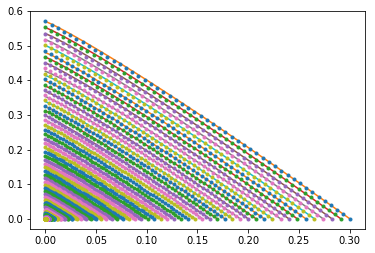

In [7]:
def model(L, *par): # I_r as a function of L
    return par[0]*L**par[1]+par[2]

x = Symbol('x')

ni = 50
eps = np.logspace(np.log10(0.5),np.log10(0.99), ni)
pars_l = [] # fitting parameters for L
I_l = []

# for fixed values of ε calculate I_r vs L
for a in eps:
    x_m = solve(-2*a*x**2+(1-4*a)*x+2*(1-a),x) # dlmax/dx=0 to find the corresponding x for lmax_max
# x_m_arr = sym.lambdify((a,), x_m[1])(eps)
    l = np.linspace(1e-4, 0.999*lmax(a, float(max(x_m))), ni)
    integI=[]
    errI=[]
    
    for b in l:
        sol = solve(-2*a*x**3+2*(1-a)*x**2-b**2*x-b**2, x)
#         print(sol)
        x_neg = re(sol[0])
        x_min = float(re(sol[1]))
        x_max = float(re(sol[2]))
        
        # integration
        func = lambda x: (2/(1+x)-2*a-b**2/x**2)**0.5
        integ, err = quad(func, x_min, x_max)
        integI.append(integ)
        errI.append(err)
        
    I_l.append(integI)    
    plt.errorbar(l, integI, yerr=errI, fmt='.')

    p0 = [2.2, 1, 1]
    params, cov = spopt.curve_fit(model, l, integI, p0, sigma=errI)
    pars_l.append(params)
    plt.plot(l, model(l,*params), label='model')

In [2]:
def model2(eps, *par): # I_r as a function of L
    return par[0]*eps**par[1]-par[0]

In [4]:
# ni = 30
# eps2 = np.logspace(-2,np.log10(0.95), ni)
# a = max(eps2)
# x_m = solve(-2*a*x**2+(1-4*a)*x+2*(1-a),x)
# # l2 = np.linspace(1e-4, lmax(a, float(max(x_m))), 5)

# i = 0
# b = 1e-4
# pars_eps = [] # fitting parameters for ε

# # for fixed values of L calculate I_r vs ε
# while b < lmax(max(eps2), float(max(x_m))):
#     x_m = solve(-2*a*x**2+(1-4*a)*x+2*(1-a),x) # dlmax/dx=0 to find the corresponding x for lmax_max
# # x_m_arr = sym.lambdify((a,), x_m[1])(eps)
#     integI2=[]
#     errI2=[]
    
#     for a in eps2:
#         sol = solve(-2*a*x**3+2*(1-a)*x**2-b**2*x-b**2, x)
#         #print(sol)
#         x_neg = re(sol[0])
#         x_min = float(re(sol[1]))
#         x_max = float(re(sol[2]))

#         # integration
#         func = lambda x: (2/(1+x)-2*a-b**2/x**2)**0.5
#         integ, err = quad(func, x_min, x_max)
#         integI2.append(integ)
#         errI2.append(err)
        
#     plt.errorbar(eps2, integI2, yerr=errI2, fmt='.')

#     # fitting
#     xval = eps2
#     yval = np.nan_to_num(integI2)
#     p0 = [1, -1, 2]
#     params, cov = spopt.curve_fit(model2, xval, yval, p0=p0, sigma=errI2)
#     pars_eps.append(params)
#     plt.plot(eps2, model2(eps2,*params), label='model')

#     b += 0.0001

In [8]:
np.savetxt('L_params', pars_l)
np.savetxt('I_l', I_l)
# np.savetxt('eps_params', pars_e)

In [3]:
pars_l = np.loadtxt('L_params')
pars_eps = np.loadtxt('eps_params')
I_l = np.loadtxt('I_l')
eps = np.logspace(np.log10(0.5),np.log10(0.99), ni)

L parameters average (coef, index): -2.2074102757813776 1.0841630134737343
ε parameters average (coef, index): 0.9762673469389893 -0.7430285641606352


Text(0, 0.5, 'L index')

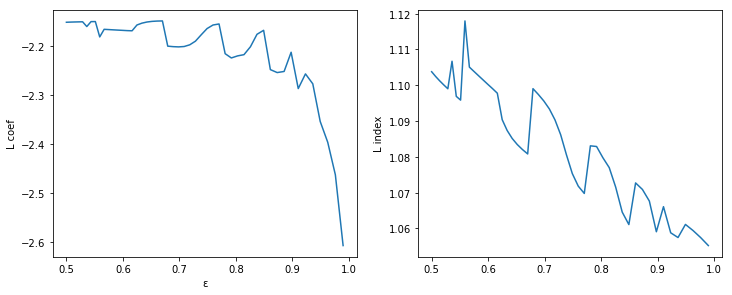

In [9]:
pars_l = np.array(pars_l)
l_index = np.average(pars_l[:,1])
l_coef = np.average(pars_l[:,0])
print('L parameters average (coef, index):', l_coef, l_index)

pars_eps = np.array(pars_eps)
eps_index = np.average(pars_eps[:,1])
eps_coef = np.average(pars_eps[:,0])
print('ε parameters average (coef, index):',eps_coef, eps_index)

plt.figure(figsize=[12,10])
# L parameters
plt.subplot(2,2,1)
plt.plot(eps, pars_l[:,0])
plt.ylabel('L coef')
plt.xlabel('ε')
plt.subplot(2,2,2)
plt.plot(eps, pars_l[:,1])
plt.ylabel('L index')

# # eps parameters
# plt.subplot(2,2,3)
# plt.plot(pars_eps[:,0])
# plt.ylabel('eps coef')
# plt.subplot(2,2,4)
# plt.plot(pars_eps[:,1])
# plt.ylabel('eps index')
plt.show()

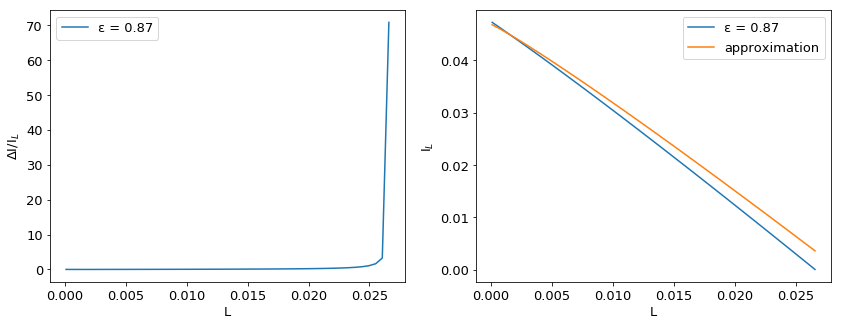

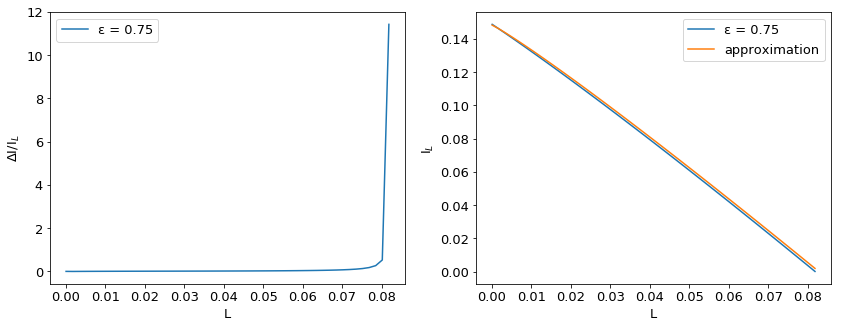

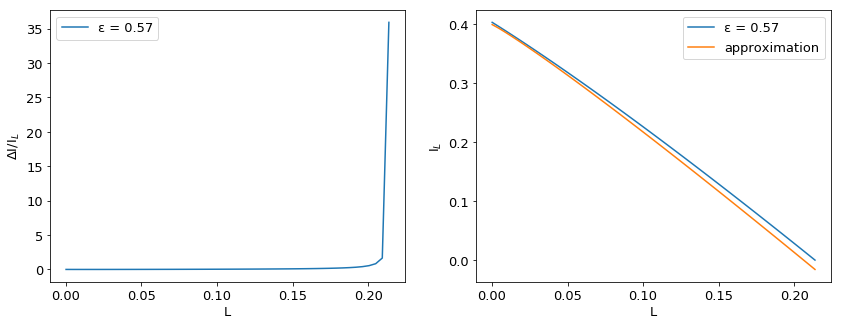

In [80]:
def plotMSE_L(i, I_l=I_l, eps=eps):
    x = Symbol('x')
    a = eps[i]
    x_m = solve(-2*a*x**2+(1-4*a)*x+2*(1-a),x) # dlmax/dx=0 to find the corresponding x for lmax_max
    l = np.linspace(1e-4, 0.99*lmax(a, float(max(x_m))), 50)

    I_lmodel = l_coef*l**l_index + pars_l[i,2]
    mse_l = np.abs(I_l[i] - I_lmodel)/(I_l[i])
    
    plt.figure(figsize=[14,5])
    plt.subplot(1,2,1)
    plt.plot(l, mse_l, label='ε = %.2f' %eps[i])
    plt.xlabel('L')
    plt.ylabel('ΔΙ/I$_L$')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(l, I_l[i], label='ε = %.2f' %eps[i])
    plt.plot(l, I_lmodel, label='approximation')
    plt.xlabel('L')
    plt.ylabel('I$_L$')
    plt.legend()
    
plotMSE_L(40)
plotMSE_L(29)
plotMSE_L(10)

0.19337019093731692
fitting params [ 0.13673337 -2.01310722]


/home/jagoras/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/jagoras/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


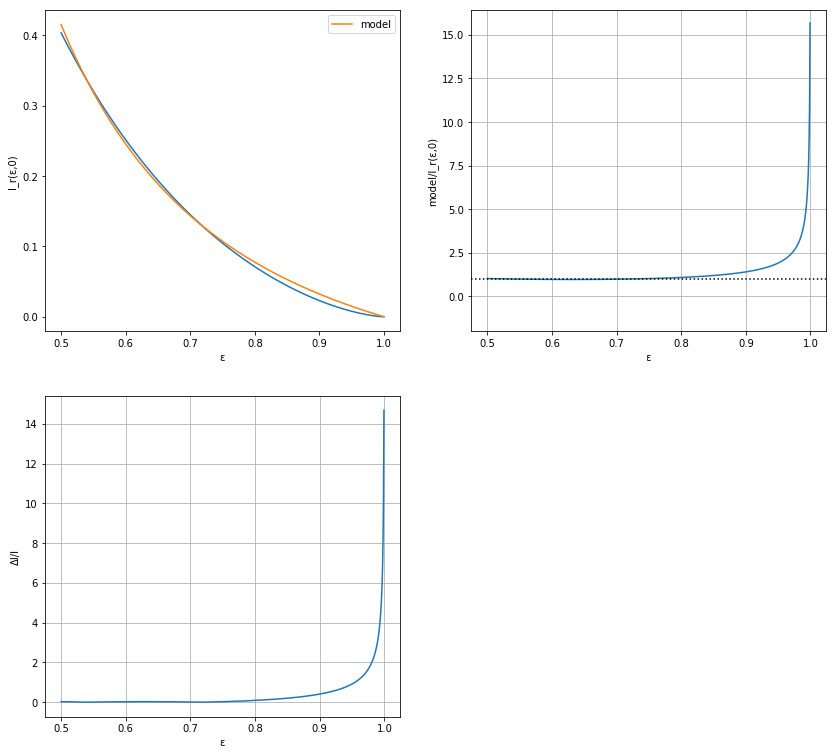

0.0


In [12]:
n = 1000
eps = np.logspace(np.log10(0.5),0,n)
I_eps = np.arccos(eps**0.5)/eps**0.5 - (1-eps)**0.5
# interpolation
eps_I = interp1d(I_eps, eps)

# fitting
params, cov = spopt.curve_fit(model2, eps, I_eps, [1, -1])
A = params[0]*np.sqrt(2)
B = params[1]
print(A)
print('fitting params', params)

plt.figure(figsize=[14,13])
plt.subplot(2,2,1)
plt.plot(eps, I_eps)
plt.plot(eps, model2(eps,*params), label='model')
plt.xlabel('ε')
plt.ylabel('I_r(ε,0)')
plt.legend()

plt.subplot(2,2,2)
plt.plot(eps, model2(eps,*params)/I_eps, label='model')
plt.xlabel('ε')
plt.ylabel('model/I_r(ε,0)')
plt.axhline(1, linestyle=':', color='k')
plt.ylim(-2)
plt.grid()

dI = np.abs(model2(eps,*params)-I_eps)/I_eps # mean squared error

plt.subplot(2,2,3)
plt.plot(eps, dI)
plt.xlabel('ε')
plt.ylabel('ΔI/I')
plt.grid()
plt.show()
print(min(I_eps))

In [13]:
# eps = np.logspace(-2,np.log10(0.95),50)

# def plotMSE(i, I_l=I_l, eps=eps):
#     x = Symbol('x')
#     a = eps[i]
#     x_m = solve(-2*a*x**2+(1-4*a)*x+2*(1-a),x) # dlmax/dx=0 to find the corresponding x for lmax_max
#     l = np.linspace(1e-4, 0.99*lmax(a, float(max(x_m))), 50)
#     I_eps = np.arccos(eps[i]**0.5)/eps[i]**0.5 - (1-eps[i])**0.5


#     I_model = -2.13*l**1.14 + 1.9*eps[i]**(-0.53) - 2.15
#     I_num = I_l[i] + 0.2**0.5 * I_eps
#     MSE = (I_num - I_model)**2/len(I_num)
    
#     plt.figure(figsize=[14,5])
#     plt.subplot(1,2,1)
#     plt.plot(l, MSE, label='ε = %.2f' %eps[i])
#     plt.xlabel('L')
#     plt.ylabel('MSE')
#     plt.legend()
    
#     plt.subplot(1,2,2)
#     plt.plot(l, I_num, label='ε = %.2f' %eps[i])
#     plt.plot(l, I_model, label='model')
#     plt.xlabel('L')
#     plt.ylabel('I$_r$(ε, L)')
#     plt.legend()
    
# plotMSE(40)

In [55]:
# density profile

## parameters
c = const.c.to(units.parsec/units.s)
a = 3e3 *units.parsec# scale radius
G = const.G.to(units.parsec**3/units.solMass/units.s**2)
m = 2.6e6* units.solMass # BH mass
M = 1e10 * units.solMass # initial halo mass
Rs = (2*G*m/c**2).to(units.parsec)
m_tild = (m/M).value
Lmin = ((2*c * Rs)/(a*G*M)**0.5).value

ni = 10
r = np.logspace(np.log10(4.001*Rs.value), 2, 50)
x_arr = r/a.value

# self-annihilation
t_bh = 1e10 *units.year # age of the BH
sigmav = 3e-26 *units.cm**3/units.s # WIMP annihilation cross-section
m = (100 *units.GeV/c**2).to(units.solMass) # DM particle mass
rho_core = (m/(sigmav*t_bh)).to(units.solMass/units.parsec**3).value

In [56]:
# density profile
## integration

int_rho_arr = []
int_err = []

for xi in x_arr:

    def f_integ(z, u):
        eps_max = m_tild/(xi)*(1 - 4*Rs/(a*xi))
        eps_f = u*eps_max
        Lmax2 = 2*xi**2*(m_tild/(xi) - eps_f)
        l = z*Lmax2 + (1-z)*Lmin**2
#         eps_i = ((1/A * (np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index + A)) ** (1/B)).value
#         eps_i = np.clip(eps_i, 0, 0.9999)
        eps_i = eps_I(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index)
        

        # distribution function
        f_H = eps_i**0.5/(1-eps_i)**2 * ((1-2*eps_i)*(8*eps_i**2-8*eps_i-3) + 3*np.arcsin(eps_i**0.5)/np.sqrt(eps_i*(1-eps_i)))
        if (Lmax2-Lmin**2) < 0:
            return 0
        else:
            return np.sqrt((Lmax2-Lmin**2)/(1-z)) * f_H
        
    # integration
    integ_rho = dblquad(f_integ, 0, 1, 0, 1, epsrel=1e-3)
    int_rho_arr.append(integ_rho[0])
    int_err.append(integ_rho[1])

In [67]:
np.savetxt('Hernquist integ100', int_rho_arr)
np.savetxt('Hernq_integ error100', int_err)

In [65]:
# int_rho_arr = np.loadtxt('Hernquist integ')
# int_err = np.loadtxt('Hernq_integ error')
rho_GS = np.loadtxt('rho_sp1 compare')
rho_GS16 = np.loadtxt('rho_sp16')
r_GS = np.logspace(np.log10(4.01*Rs.value), 4, 100)

[51.92665026  2.74962963 -2.74966665]


(1e-05, 4.606352836654724e+17)

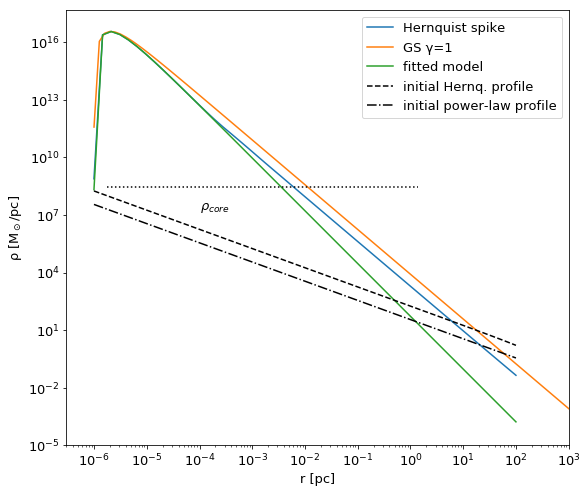

In [72]:
def spike_model(r, *par, Rs=Rs.value):
    return par[0]*(1-4*Rs/r)**par[1] * r**par[2]

def rho0(r_0, gamma): # from GS
    return (1-gamma/3)*0.0062*(8500/r_0)**gamma

eps_max = m_tild/(x_arr)*(1 - 4*Rs/(a*x_arr))
rho = (1/(2**0.5 * (2*np.pi)**2 *x_arr) * (M/a**3)*eps_max) * np.array(int_rho_arr)
rho_H = (M/(2*np.pi*a**3)) / ((r/a.value)*(1+r/a.value)**3)

pars, cov = spopt.curve_fit(spike_model, r, rho, p0=[100, 2.75, -4], sigma=int_err)
print(pars)

plt.figure(figsize=[9,8])
plt.plot(r, rho, label='Hernquist spike')
plt.plot(r_GS, rho_GS, label='GS γ=1')
plt.plot(r, spike_model(r, *pars), label='fitted model')
plt.plot(r, rho_H, linestyle='--', color='k', label='initial Hernq. profile')

rho_i = rho0(0.1, 1)*(0.1/r)
plt.plot(r, rho_i, color='black', linestyle='dashdot', label='initial power-law profile')
plt.axhline(rho_core, 0.08, 0.7, linestyle=':', color='black')
plt.text(1e-4,2e7, '$ρ_{core}$')

plt.xlabel('r [pc]')
plt.ylabel('ρ [M$_\odot$/pc]')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(3e-7,1000)
plt.ylim(1e-5)

Text(0, 0.5, '(ρ$_{num}$-ρ$_{model}$)/ρ$_{num}$')

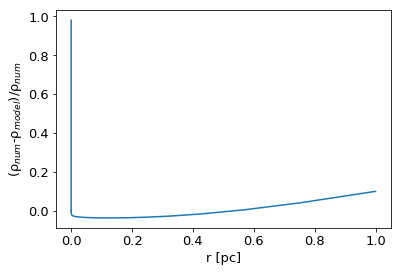

In [53]:
plt.plot(r, (rho.value-spike_model(r, *pars))/rho.value, label='numerical/model ratio')
plt.xlabel('r [pc]')
plt.ylabel('(ρ$_{num}$-ρ$_{model}$)/ρ$_{num}$')


Text(0, 0.5, 'ε_i(L=0)')

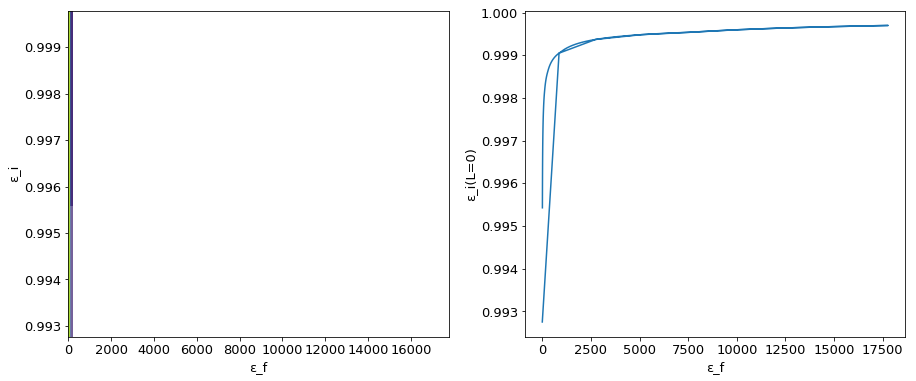

In [86]:
# testing
r = np.logspace(np.log10(4.01*Rs.value), -1, 100)
a = 3e3 *units.parsec# scale radius

x_arr = r/a.value

u = np.linspace(0.001,0.999,100)
z = np.linspace(0.001,0.999,100)
eps_max = m_tild/(x_arr)*(1 - 4*Rs/(a*x_arr)).value
eps_f = u*eps_max
Lmax2 = 2*x_arr**2*(m_tild/(x_arr) - eps_f)
l = (z*Lmax2 + (1-z)*Lmin**2)**0.5
# eps_i = ((1/A * (np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index + A)) ** (1/B))
# eps_i = np.clip(eps_i, 0, 0.99999)
eps_i = eps_I(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index)

# for L=0
eps_i0 = eps_I(np.pi*(m_tild/(np.sqrt(2*eps_f))))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
eps_fv, eps_iv = np.meshgrid(eps_f, eps_i)
Lmax2v = 2*x_arr**2*(1/(1+x_arr) - eps_fv/eps_max)
lv = (z*Lmax2v + (1-z)*Lmin**2)**0.5
plt.contour(eps_fv, eps_iv, lv)
plt.xlabel('ε_f')
plt.ylabel('ε_i')

plt.subplot(1,2,2)
plt.plot(eps_f, eps_i0)
plt.xlabel('ε_f')
plt.ylabel('ε_i(L=0)')

In [69]:
eps_i

NameError: name 'eps_i' is not defined

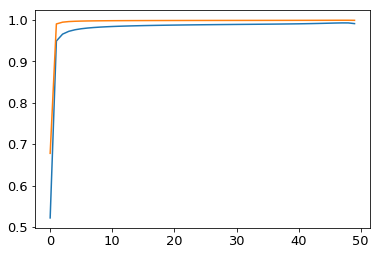

In [104]:
plt.plot(eps_I(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index))
plt.plot(eps_i)

In [50]:
(units.GeV/const.c**2/units.cm**3).to(units.solMass/units.parsec**3)

<Quantity 0.02633907 solMass / pc3>

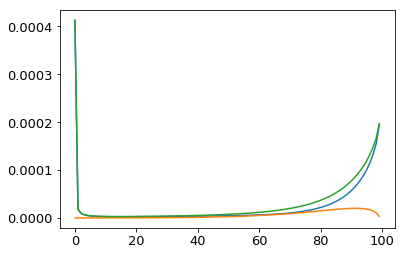

In [87]:
plt.plot(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l))
plt.plot(- l_coef*l**l_index)
plt.plot(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l)- l_coef*l**l_index)

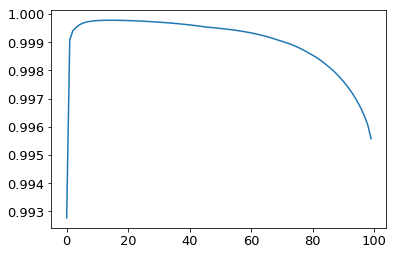

In [89]:
plt.plot(eps_i)


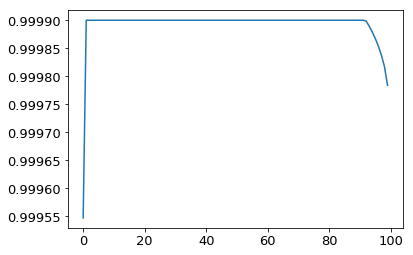

In [91]:
eps_i = ((1/A * (np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index + A)) ** (1/B))
eps_i = np.clip(eps_i, 0, 0.9999)
plt.plot(eps_i)